## Explicabilidade

Este trabalho tem como objetivo o treinamento de modelos explicáveis para o problema de análise de crimes segundo características socio-econômicas nas regiões de São Paulo. Aqui, retornamos ao uso de todas as variáveis socio-econômicas para obtenção de explicações completas acerca da origem e desenvolvimento criminal nas regiões. No entanto, utilizaremos uma arquitetura de modelos diferente das utilizadas nos trabalhos anteriores.

O desafio de prever crimes numa região poderia ser modelada como uma regressão para prever a distribuição dos boletins de ocorrência, por exemplo, no tempo. No entanto, regiões com baixo índice de criminalidade não possuem amostras de boletins de ocorrência capazes de se extrair uma distribuição que modele os BOs de forma satisfatória, ou até mesmo fiel. A forma que encontramos para minimizar este problema anteriormente foi de modelar o problema como um problema de classificação em regiões perigosas ou não, baseado apenas na quantidade de BOs registrados em dada região. No entanto, este tipo de redução carrega inúmeros vieses e não é justo para tomar qualquer tipo de decisão, principalmente devido a ambiguidade que um hard threshold causa ao diferenciar amostras cujo padrão é semelhante, mas o ground-truth induzido não é, por exemplo, classificar como perigoso regiões com mais de 1 BOs por dia em média classifica regiões com 0.99 BOs por dia como seguros.

Pensando nisso e numa forma de se aprimorar o problema em si de forma que sua saída seja mais fácil de ser explicada, utilizamos um modelo híbrido de Regressão Inflada em zero. Esta abordagem melhora a capacidade de explicação ao separar regiões perigosas de não perigosas (zero e não-zero) e então obter um modelo de regressão para regiões perigosas, o que garante modelos capazes de quantificar a incidência criminal e não apenas sua existência.

### Revisão Bibliográfica

[Curiel et. al](https://link.springer.com/article/10.1007/s10940-017-9354-9) argumenta que a distribuição de ocorrências criminais ocorre segundo uma distribuição de Poisson-Binomial, onde cada indivíduo é selecionado por uma Binomial e então a ocorrência é modelada por uma distribuição de Poisson. Deste modo, escolhemos tratar nosso problema de forma que cada região é tratada como uma amostra de uma distribuição de Poisson que tenta prever a quantidade de BOs relatados naquela região. Uma regressão de Poisson utiliza um aproximador de esperança dado por

$$\mathbb{E}[y \,|\, x] = \exp(\theta^Tx)$$

Que induz uma distribuição de probabilidade condicional de Poisson

$$p_\theta(y \,|\, x) = \frac{\exp(y \cdot \theta^Tx)}{y!} \exp(-e^{\theta^Tx})$$

Os parâmetros $\theta$ são então otimizados de forma a maximizar a verossimilhança dos dados $\mathcal{D} = \{x^{(i)}, y^{(i)}\}_{i=1}^N$, 

$$\theta = \argmax_{\theta}\prod_{i=1}^N p_\theta(y_i \,|\, x_i)$$

Como trata-se de um problema de regressão em que 

In [1]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline, make_pipeline
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme('notebook', 'whitegrid', 'Set1')

In [2]:
data = pd.read_csv('../dataset/Padrão Urbano/PU.csv', sep=';')

selected_columns = set(''.join([i for i in column if not i.isdigit()]) for column in data.columns)
selected_columns = [f"{column}10"if len(column) == 3 else column for column in selected_columns]

X = data[selected_columns].drop(columns=['SETTT'])

categ_columns = ['HOMIC', 'ARISC', 'PMANC', 'EXURB', 'AGL10', 'DEN10', 'CLUSTER']
log_columns = ['VIAGEM', 'POP10']

X['CLUSTER'] = OrdinalEncoder().fit_transform(X[['CLUSTER']])

X.head(5)

,CAR10,HOMIC,TDESL,CAL10,AGL10,ARISC,CLUSTER,POP10,ESG10,VER10,PMANC,CMU10,PJM10,VIAGEM,EXURB,LIX10,AGU10,DPP10,DPI10,DEN10
0,0.0224,1,29.8,0.9925,0,0,2.0,806,1.0,0.0410,0,0.3619,0.0558,1428.9,2,0.9962,1.0,0.9925,0.0075,2
1,0.0163,1,21.7,0.9706,0,0,0.0,913,1.0,0.0000,0,0.3268,0.0701,1554.2,1,1.0000,1.0,1.0000,0.0000,2
2,0.0106,1,25.8,0.9788,0,0,2.0,625,1.0,0.0370,0,0.4392,0.0560,1471.5,2,1.0000,1.0,1.0000,0.0000,2
3,0.0055,2,27.7,0.9834,0,0,1.0,572,1.0,0.1271,0,0.5414,0.0752,1404.8,2,1.0000,1.0,1.0000,0.0000,2
4,0.0000,2,28.6,0.9667,0,0,1.0,754,1.0,0.0500,0,0.4458,0.0809,1492.0,2,1.0000,1.0,1.0000,0.0000,2


In [3]:
crimes = pd.read_csv('../dataset/Crimes/Listagem_Geral.csv', index_col=0)

crimes["DATA"] = pd.to_datetime(crimes["DATA"])

counts = crimes['SETOR'].value_counts()

y = data['SETTT'].apply(lambda setor : counts.get(setor, 0)).to_numpy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
frac = 0.8

n_aug_samples = int(len(X_train) * frac)

idx = np.random.randint(0, len(X_train), size=n_aug_samples)

X_aug = X_train.iloc[idx].copy()

X_aug["CAR10"] = X_train["CAR10"].sample(n=n_aug_samples, replace=True, random_state=21).to_numpy()

y_aug = y_train[idx]

X_aug = pd.concat([X_train, X_aug])
y_aug = np.hstack([y_train, y_aug])

In [6]:
from sklearn.model_selection import KFold
from tqdm import tqdm

def evaluate(models, X, y, metrics, cv=20, df=None, figname=None):
    if df is None:
        df = pd.DataFrame(columns=metrics.keys())
    
    results = {}
    for name, model in models.items():
        scores = {metric : [] for metric in metrics}

        for train_idx, val_idx in tqdm(KFold(n_splits=cv).split(X, y)):
            model.fit(X.iloc[train_idx], y[train_idx])

            for metric_name, metric in metrics.items():
                scores[metric_name].append(metric(model, X.iloc[val_idx], y[val_idx]))

        results[name] = scores
        df.loc[name, :] = scores

        model.fit(X, y)

    return df

def plot_results(results, models, metrics, figname=None):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title('Algorithm Comparison')

    n_metrics = len(metrics)
    n_models  = len(models)

    names = list(models.keys())

    spacing = 0.1
    delta   = (1 - spacing)*(1 - 1/n_metrics)/2

    positions = np.hstack([np.linspace(i - delta, i + delta, n_metrics) for i in range(n_models)])
    boxes = plt.boxplot(np.array([results.loc[model, metric] for model in models for metric in metrics]).T, positions=positions, widths=1.5*delta/(n_metrics-1), patch_artist=True)

    ax.xaxis.set_major_formatter(lambda _, i : names[i//n_metrics] if i%n_metrics==1 else '')
    
    for i in range(n_metrics * n_models):
        color = sns.color_palette(n_colors=n_metrics)[i%n_metrics]

        boxes['boxes'][i].set_color((1, 1, 1, 0.4))
        boxes['boxes'][i].set(facecolor=color, alpha=0.8)
        boxes['medians'][i].set_color((0, 0, 0, 0.4))
        boxes['whiskers'][2*i].set_color(color)
        boxes['whiskers'][2*i+1].set_color(color)
        boxes['caps'][2*i].set_color(color)
        boxes['caps'][2*i+1].set_color(color)
        boxes['fliers'][i].set_color(color)
        boxes['fliers'][i].set_color(color)

    for i, metric in enumerate(metrics):
        boxes['boxes'][i].set_label(metric)

    plt.ylabel("Score")
    plt.legend(frameon=True, bbox_to_anchor=(1.1, 1.05))
    plt.ylim(0, 100)

    if figname is not None:
        plt.savefig(f"{figname}.png")

    plt.show()

def style(df, format_table):

    new_df = df.applymap(lambda x : f"{np.mean(x)} $\pm$ {np.std(x)}")
    return new_df.style.highlight_max().format(format_table,)


In [7]:
from sklearn.metrics import get_scorer, pairwise_distances, balanced_accuracy_score, get_scorer_names

def consistency_score(estimator, X, y, k_neigh=5, metric="euclidean"):
    distances = pairwise_distances(X, metric=metric)

    y_pred = estimator.predict(X)

    y_neigh = y_pred[np.argsort(distances, axis=1)[:, 1:k_neigh+1]].mean(axis=1)

    return np.abs(y_pred - y_neigh).mean()

def regression_accuracy(estimator, X, y, lim=1):
    y_pred = estimator.predict(X)

    y_pred = np.where(y_pred > lim, 1, 0)
    y_norm = np.where(y > lim, 1, 0)

    return 100*balanced_accuracy_score(y_norm, y_pred)


metrics = {
    "MAE" : lambda *args : -get_scorer("neg_mean_absolute_error")(*args),
    "Bal Acc" : regression_accuracy,
    "Consistency" : consistency_score
}

format_table = {
    "MAE" : "{:3f}",
    "Bal Acc" : "{:.2%}",
    "Consistency" : "{:3f}"
}

In [8]:
def round_down(n):
    if n == 0: return 0

    base = 10**np.floor(np.log10(np.abs(n)))
    return np.floor(n / base) * base

def round_up(n):
    if n == 0: return 0
    
    base = 10**np.floor(np.log10(np.abs(n)))
    return np.ceil(n / base) * base

def align_axes(main_ax:plt.Axes, twin_ax:plt.Axes, new_ticks=None):
    l, u = main_ax.get_ylim()
    ticks = main_ax.get_yticks()
    ticks = ticks[(ticks >= l) & (ticks <= u)]

    ticks_given = False
    if new_ticks is None:
        lower, upper = twin_ax.get_ylim()

        max_delta = (upper - lower)/(len(ticks) - 1)

        delta     = round_up(max_delta)

        tick_min  = round_down(lower)

        tick_max  = tick_min + delta * (len(ticks) - 1)

    elif len(new_ticks) == 2:
        tick_min, tick_max = new_ticks

    elif len(new_ticks) == len(ticks): 
        tick_min, tick_max = new_ticks[0], new_ticks[-1]
        ticks_given = True

        if not isinstance(new_ticks, np.ndarray):
            new_ticks = np.array(new_ticks)
    else:
        raise TypeError("Length of the target ticks do not match with the ticks on main axes.")

    bminusa = (tick_max - tick_min) * (u - l)/(ticks[-1] - ticks[0])

    a = tick_max - (ticks[-1] - l)/(u - l) * bminusa
    b = bminusa + a

    if not ticks_given:
        new_ticks = np.linspace(tick_min, tick_max, len(ticks))

    twin_ax.set_yticks(new_ticks)
    twin_ax.set_ylim(a, b)


def plot_metrics(model, X, y, interval=(0, 100)):
    fig, ax = plt.subplots(ncols=2, figsize=(16, 5), dpi=200)

    liminf, limsup = interval

    n ,bins, patches = ax[0].hist(y, bins=np.linspace(liminf, limsup, 100), alpha=.5, label='Ground truth')
    y_pred = model.predict(X)
    percent = np.count_nonzero((y_pred >= liminf) & (y_pred <= limsup))/len(y_pred)
    
    ax[0].hist(y_pred, bins=bins, alpha=.5, label="Predicted")
    ax[0].set_xlim(*interval)
    ax[0].set_title("Distribution")
    ax[0].set_xlabel('Number of reports')
    ax[0].set_ylabel('Count')

    twin_ax = ax[0].twinx()
    cuts = np.arange(liminf, limsup)

    bal_acc = [regression_accuracy(model, X, y, cut)/100 for cut in cuts]

    twin_ax.plot(cuts, bal_acc, label="Bal Acc")

    align_axes(ax[0], twin_ax, (0, 1))

    lines, labels = ax[0].get_legend_handles_labels()
    lines2, labels2 = twin_ax.get_legend_handles_labels()
    twin_ax.legend(lines + lines2, labels + labels2, loc=0)

    res = y - y_pred

    liminf = min(np.quantile(res, percent), np.quantile(res, 1 - percent))
    limsup = max(np.quantile(res, percent), np.quantile(res, 1 - percent))

    ax[1].hist(res, bins=np.linspace(liminf, limsup, 100), alpha=.7)
    ax[1].set_title("Residual distribution")
    ax[1].set_xlim(liminf, limsup)


    plt.show()

In [9]:
def reject_outliers(data, p=0.01):
    liminf = np.quantile(data, p)
    limsup = np.quantile(data, 1-p)

    return np.array(data)[(data >= liminf) & (data <= limsup)]

### Modelos interpretáveis

In [9]:
from sklearn.linear_model import PoissonRegressor, QuantileRegressor, LinearRegression

preprocess = ColumnTransformer([
    ("log_numeric", make_pipeline(FunctionTransformer(np.log1p).set_output(transform="pandas"), StandardScaler().set_output(transform="pandas")), log_columns),
    ("onehot_categ", OneHotEncoder(sparse_output=False).set_output(transform="pandas"), categ_columns)
], remainder = StandardScaler().set_output(transform="pandas")).set_output(transform="pandas")

X_interp_aug = preprocess.fit_transform(X_aug)
X_interp     = preprocess.transform(X_train)

linear_model =  LinearRegression()

poisson_model = PoissonRegressor(solver="newton-cholesky", alpha=1e-4)

quantile_model = QuantileRegressor(quantile=0.4, alpha=1e-5, solver='highs')


models = {
    "Linear Regressor"   : linear_model,
    "Poisson Regressor"  : poisson_model,
    "Quantile Regressor" : quantile_model
}

/home/danielgardin/.local/lib/python3.8/site-packages/sklearn/preprocessing/_function_transformer.py:340: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [10]:
results = evaluate(models, X_interp_aug, y_aug, metrics, cv=10)

10it [00:05,  1.69it/s]
10it [00:19,  1.99s/it]
10it [08:58, 53.82s/it]


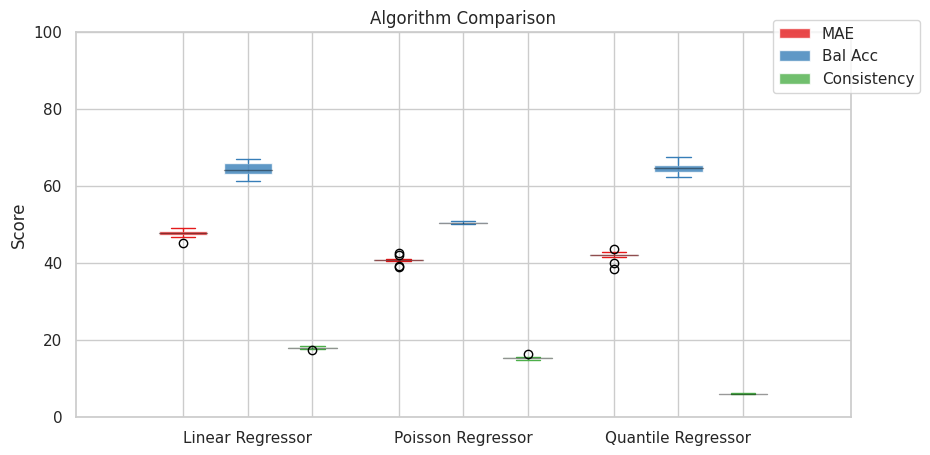

In [11]:
plot_results(results, models, metrics)

In [13]:
results.applymap(reject_outliers).applymap(lambda x : f"{np.mean(x) : .3f} $\pm$ {np.std(x) :.3f}")

,MAE,Bal Acc,Consistency
Linear Regressor,47.672 $\pm$ 0.554,64.471 $\pm$ 1.377,17.905 $\pm$ 0.166
Poisson Regressor,40.741 $\pm$ 0.708,50.457 $\pm$ 0.194,15.383 $\pm$ 0.170
Quantile Regressor,41.809 $\pm$ 0.792,64.599 $\pm$ 1.337,5.980 $\pm$ 0.067


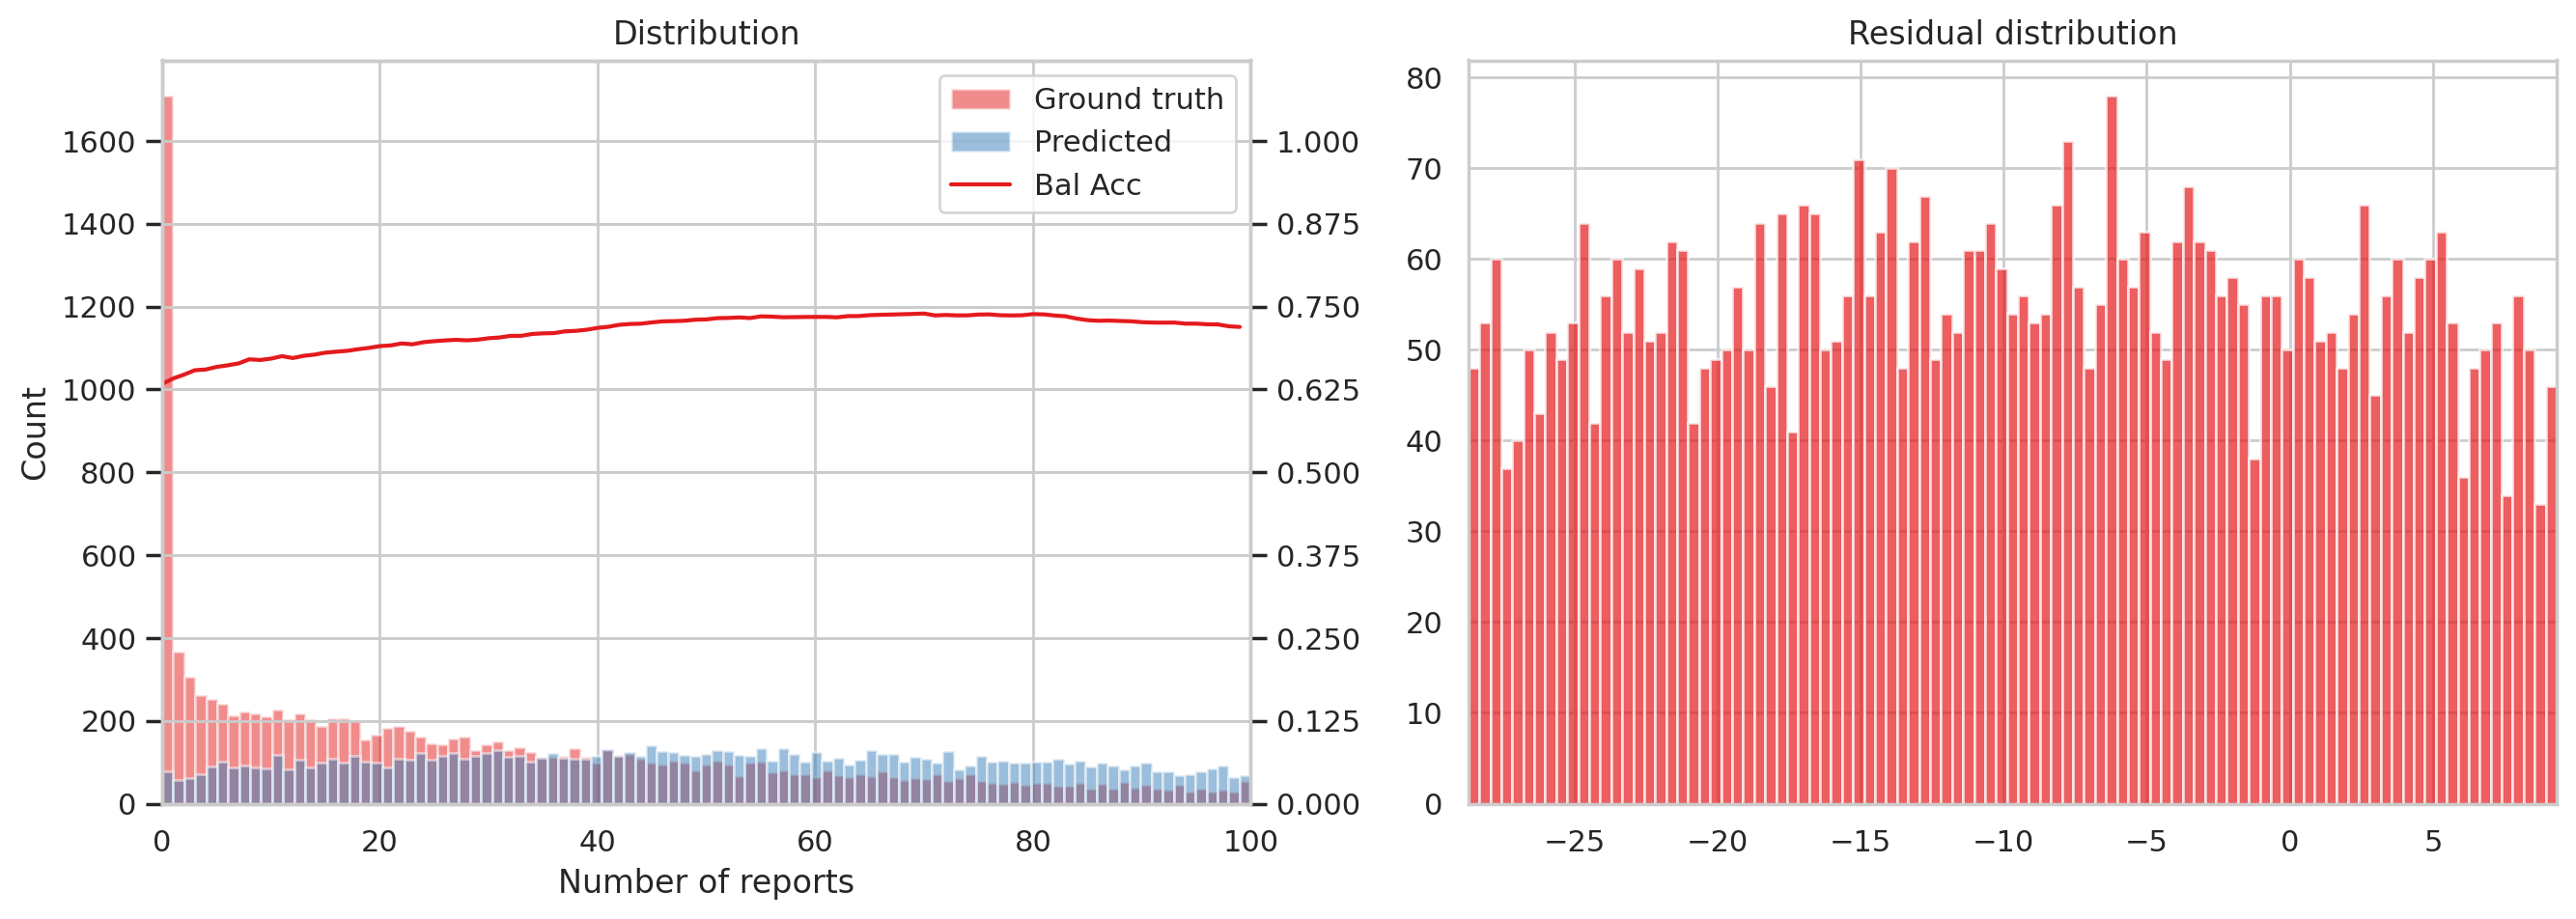

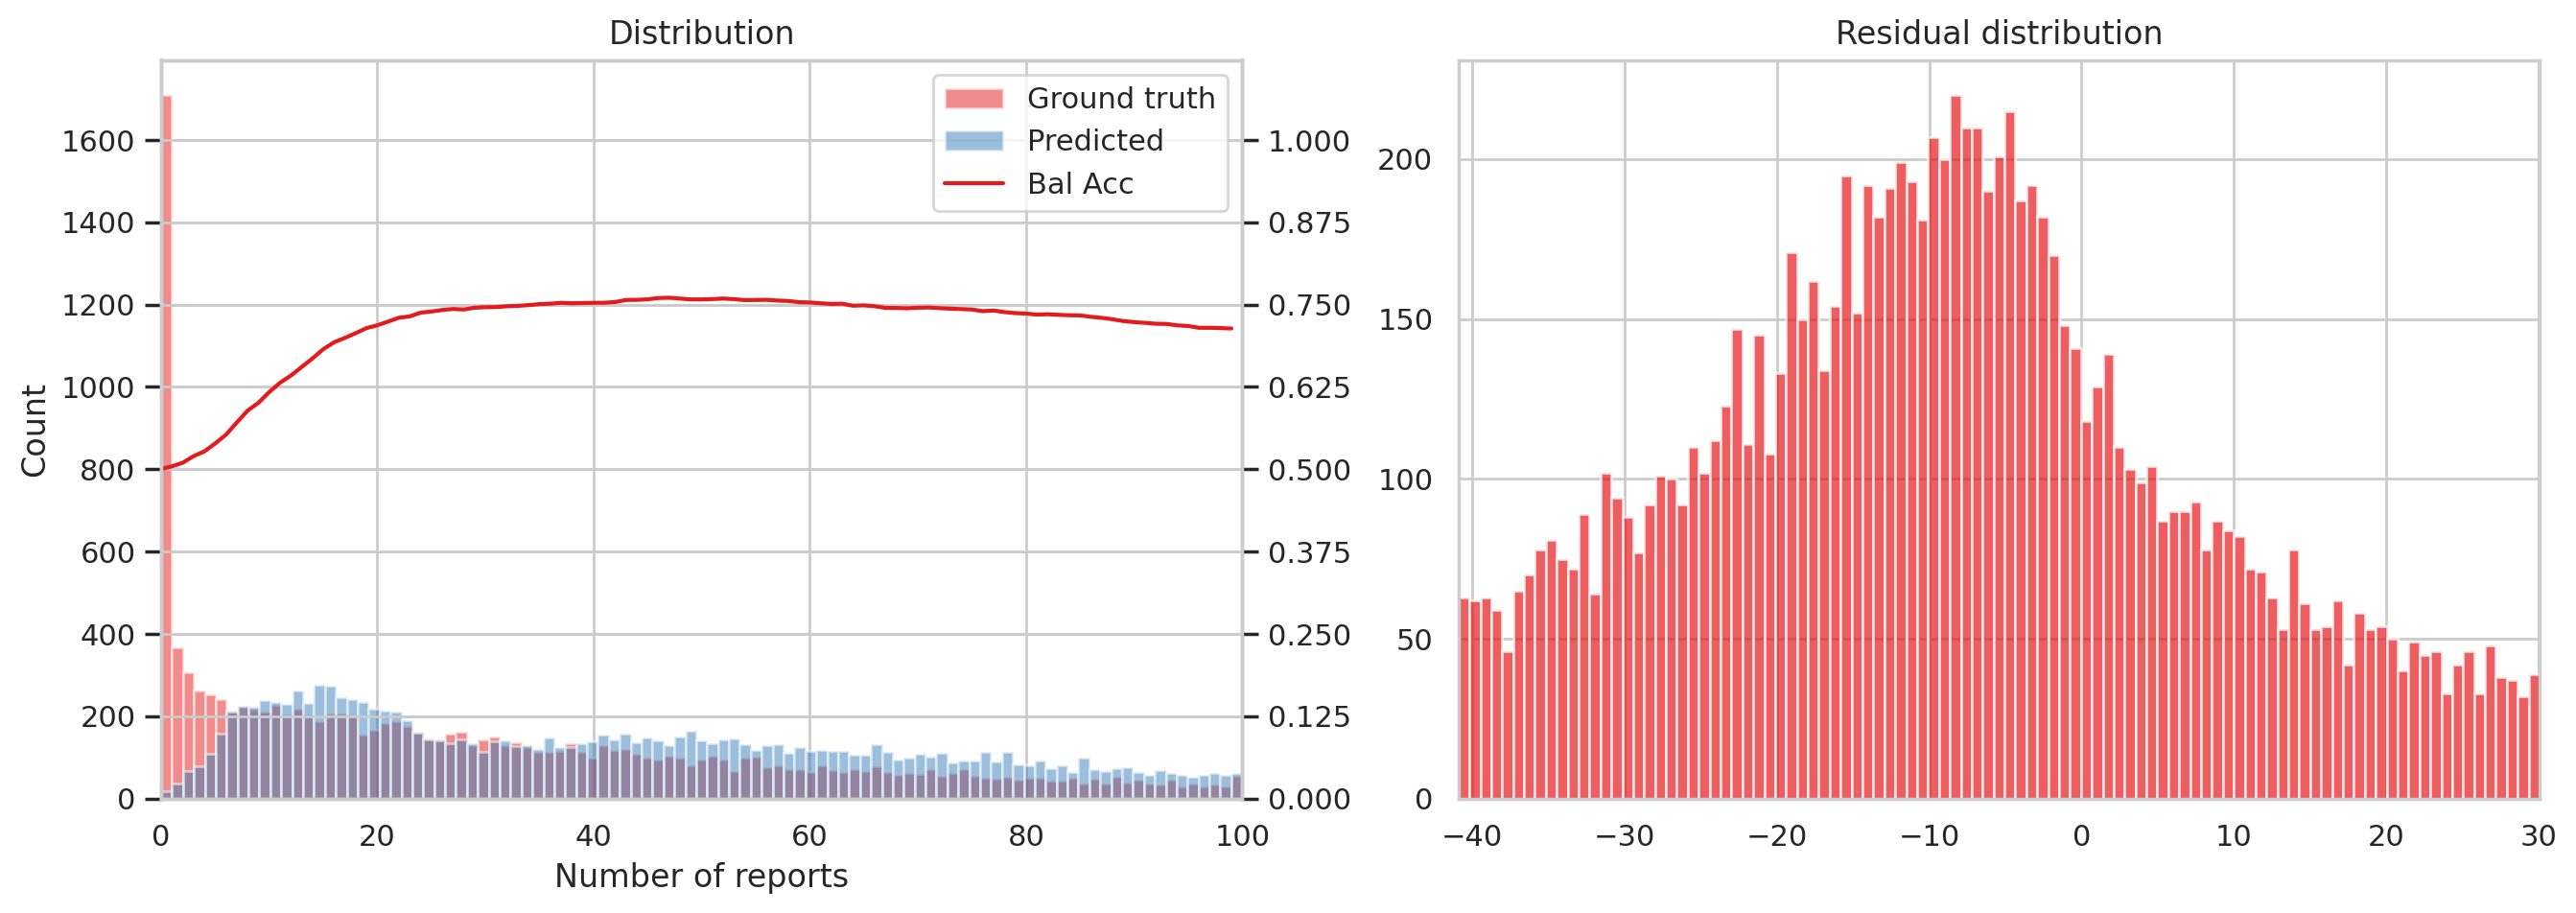

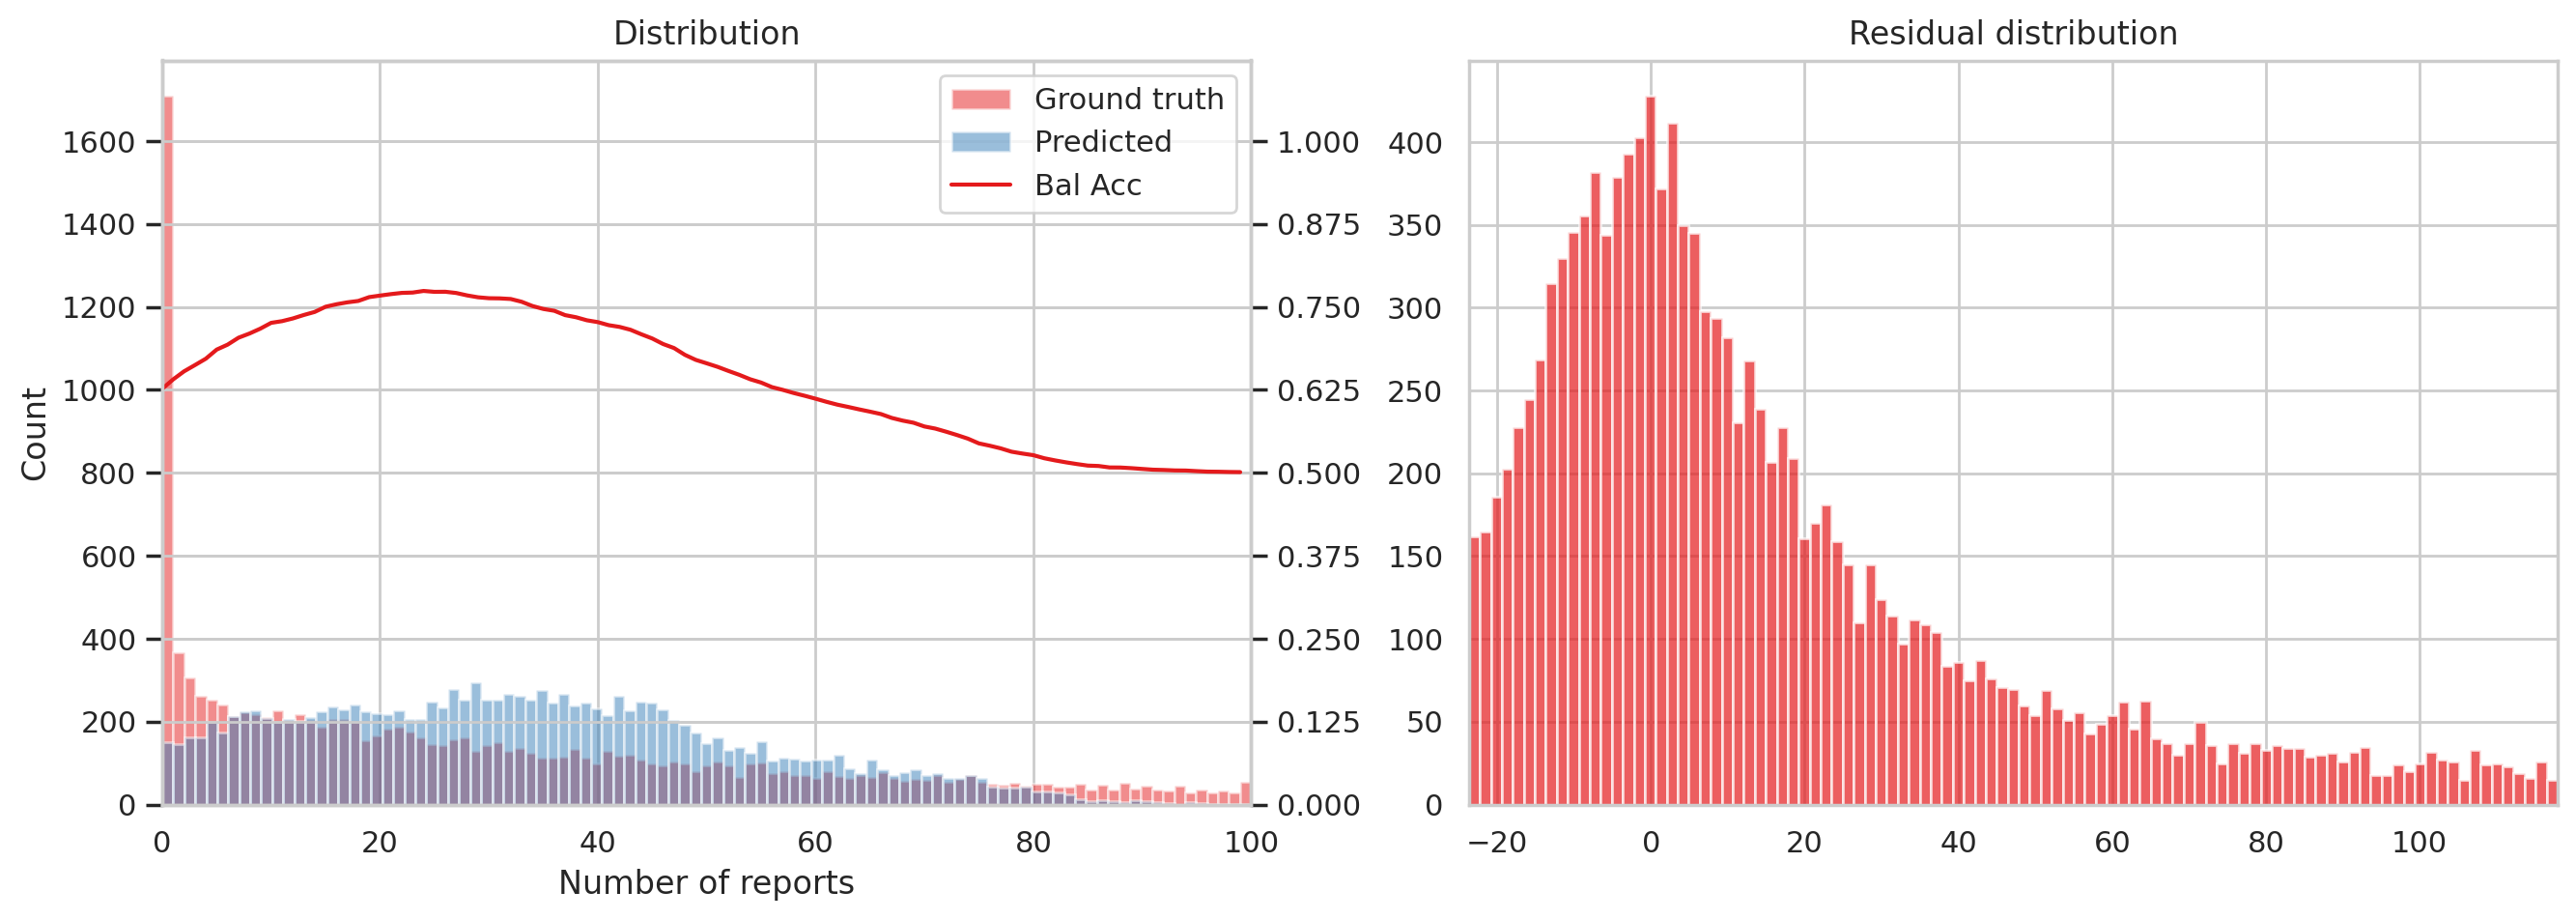

In [23]:
for model in models.values():
    plot_metrics(model, X_interp, y_train)

### Zero-Inflated Models

In [10]:
from sklearn.linear_model import LogisticRegression
from sklego.meta import ZeroInflatedRegressor

zero_inflated_models = {
    "Linear ZIR" : ZeroInflatedRegressor(
        LogisticRegression(solver="liblinear", C=1e12), LinearRegression()
    ),
    "Poisson ZIR" : ZeroInflatedRegressor(def reject_outliers(data, p=0.01):
    liminf = np.quantile(data, p)
    limsup = np.quantile(data, 1-p)

    return np.array(data)[(data >= liminf) & (data <= limsup)]
        LogisticRegression(solver="liblinear", C=1e12), PoissonRegressor(solver="newton-cholesky", alpha=1e-4)
    ),
    "Quantile ZIP": ZeroInflatedRegressor(
        LogisticRegression(solver="liblinear", C=1e12), QuantileRegressor(quantile=0.4, alpha=1e-5, solver='highs')
    )
}

In [16]:
results = evaluate(zero_inflated_models, X_interp_aug, y_aug, metrics, cv=10)

10it [00:07,  1.29it/s]
10it [00:16,  1.67s/it]
10it [08:32, 51.21s/it]


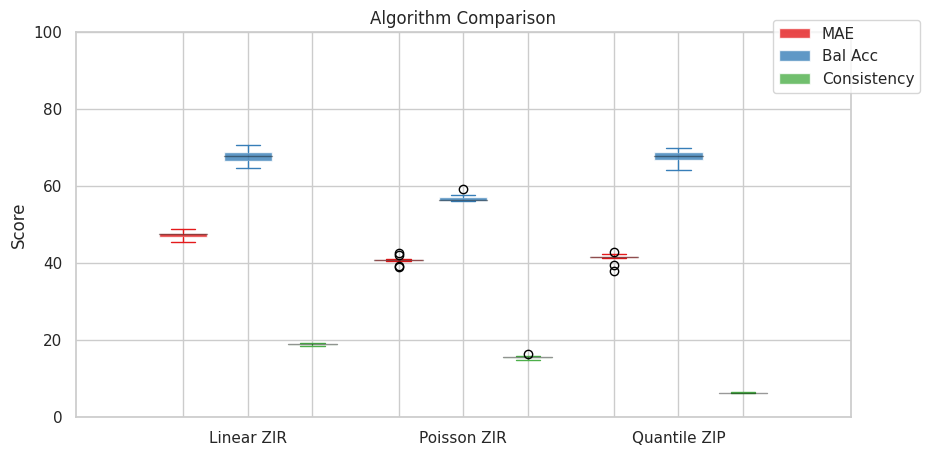

In [17]:
plot_results(results, zero_inflated_models, metrics)

In [18]:
results.applymap(reject_outliers).applymap(lambda x : f"{np.mean(x) : .3f} $\pm$ {np.std(x) :.3f}")

,MAE,Bal Acc,Consistency
Linear ZIR,47.257 $\pm$ 0.591,67.641 $\pm$ 1.034,18.878 $\pm$ 0.156
Poisson ZIR,40.695 $\pm$ 0.705,56.588 $\pm$ 0.510,15.485 $\pm$ 0.169
Quantile ZIP,41.346 $\pm$ 0.807,67.707 $\pm$ 1.013,6.195 $\pm$ 0.078


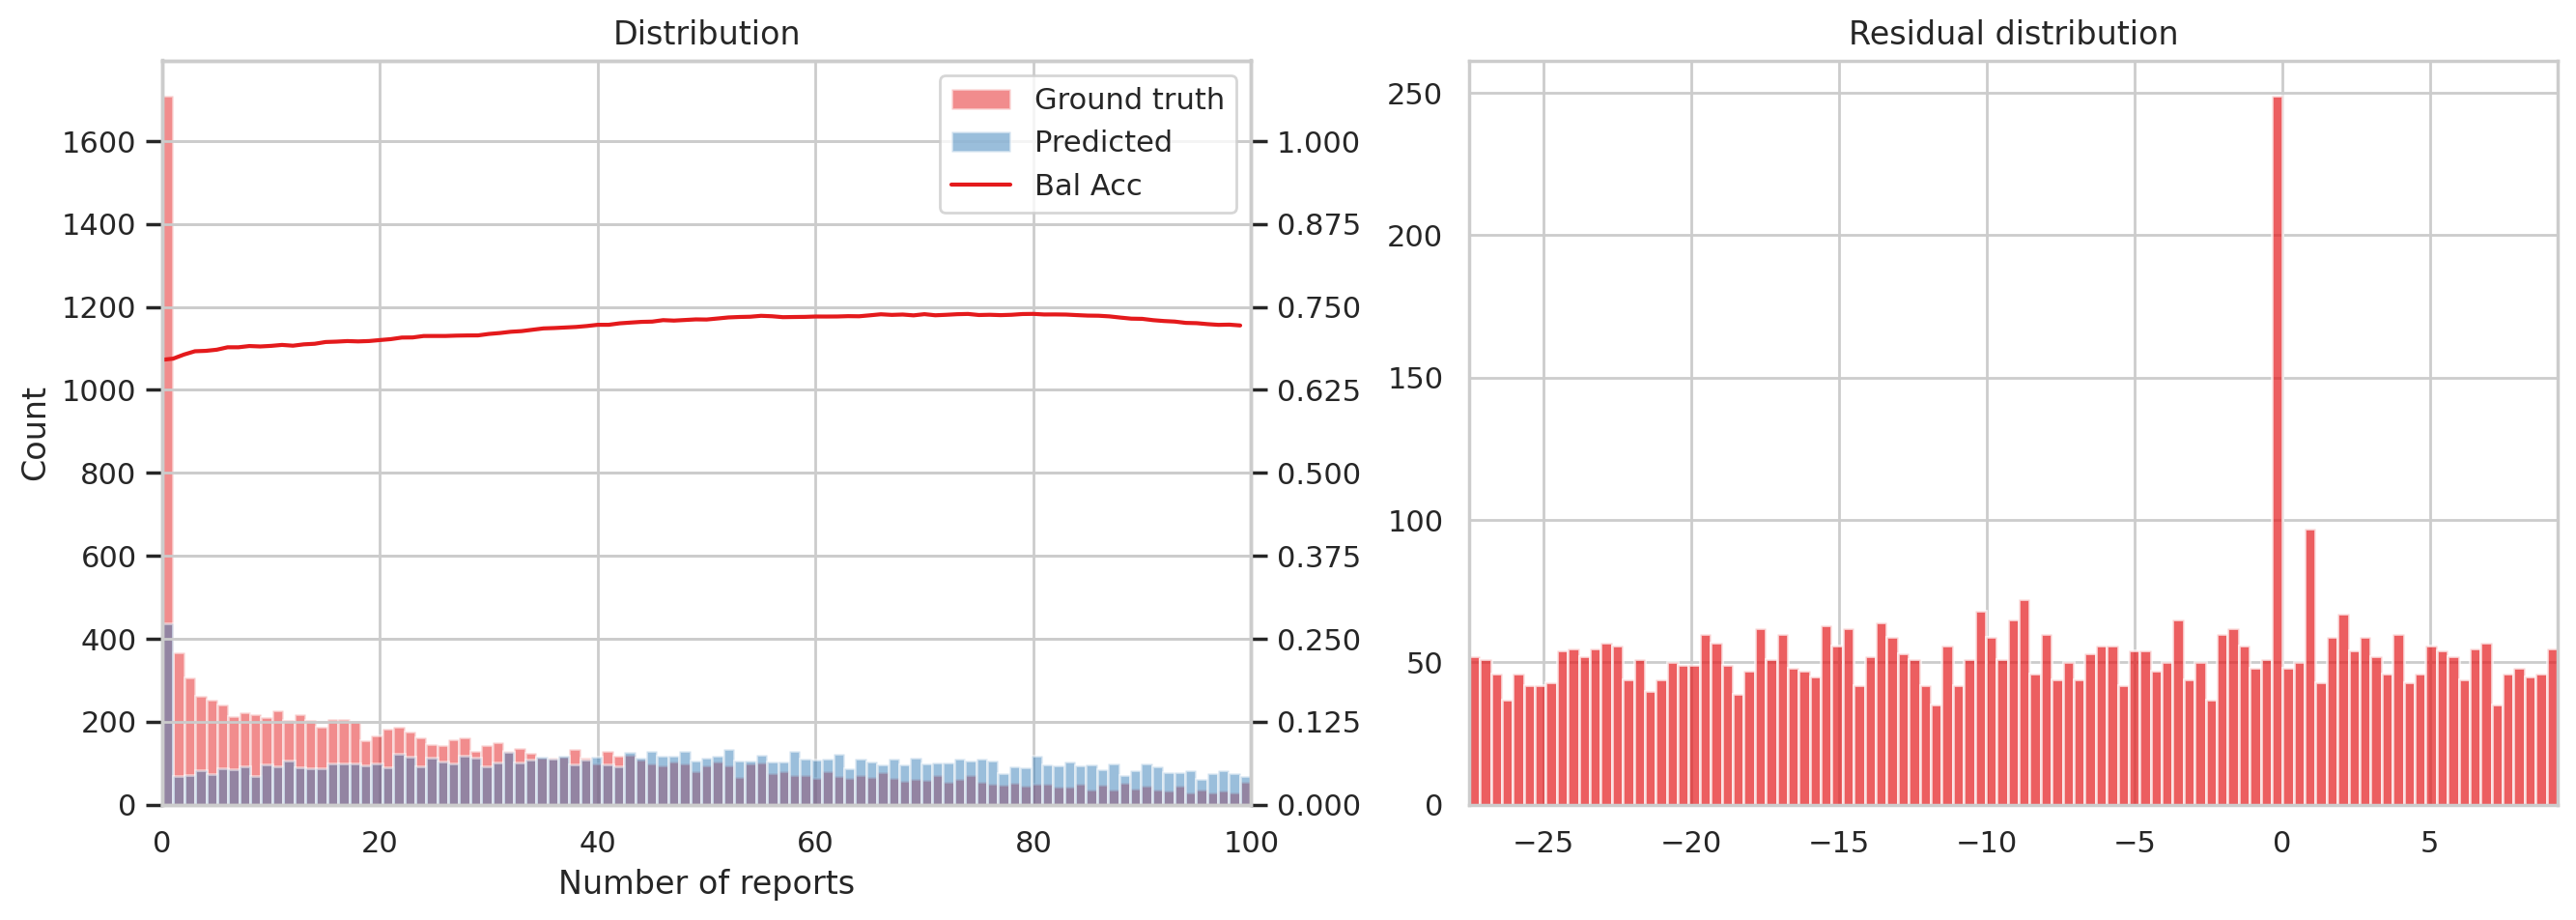

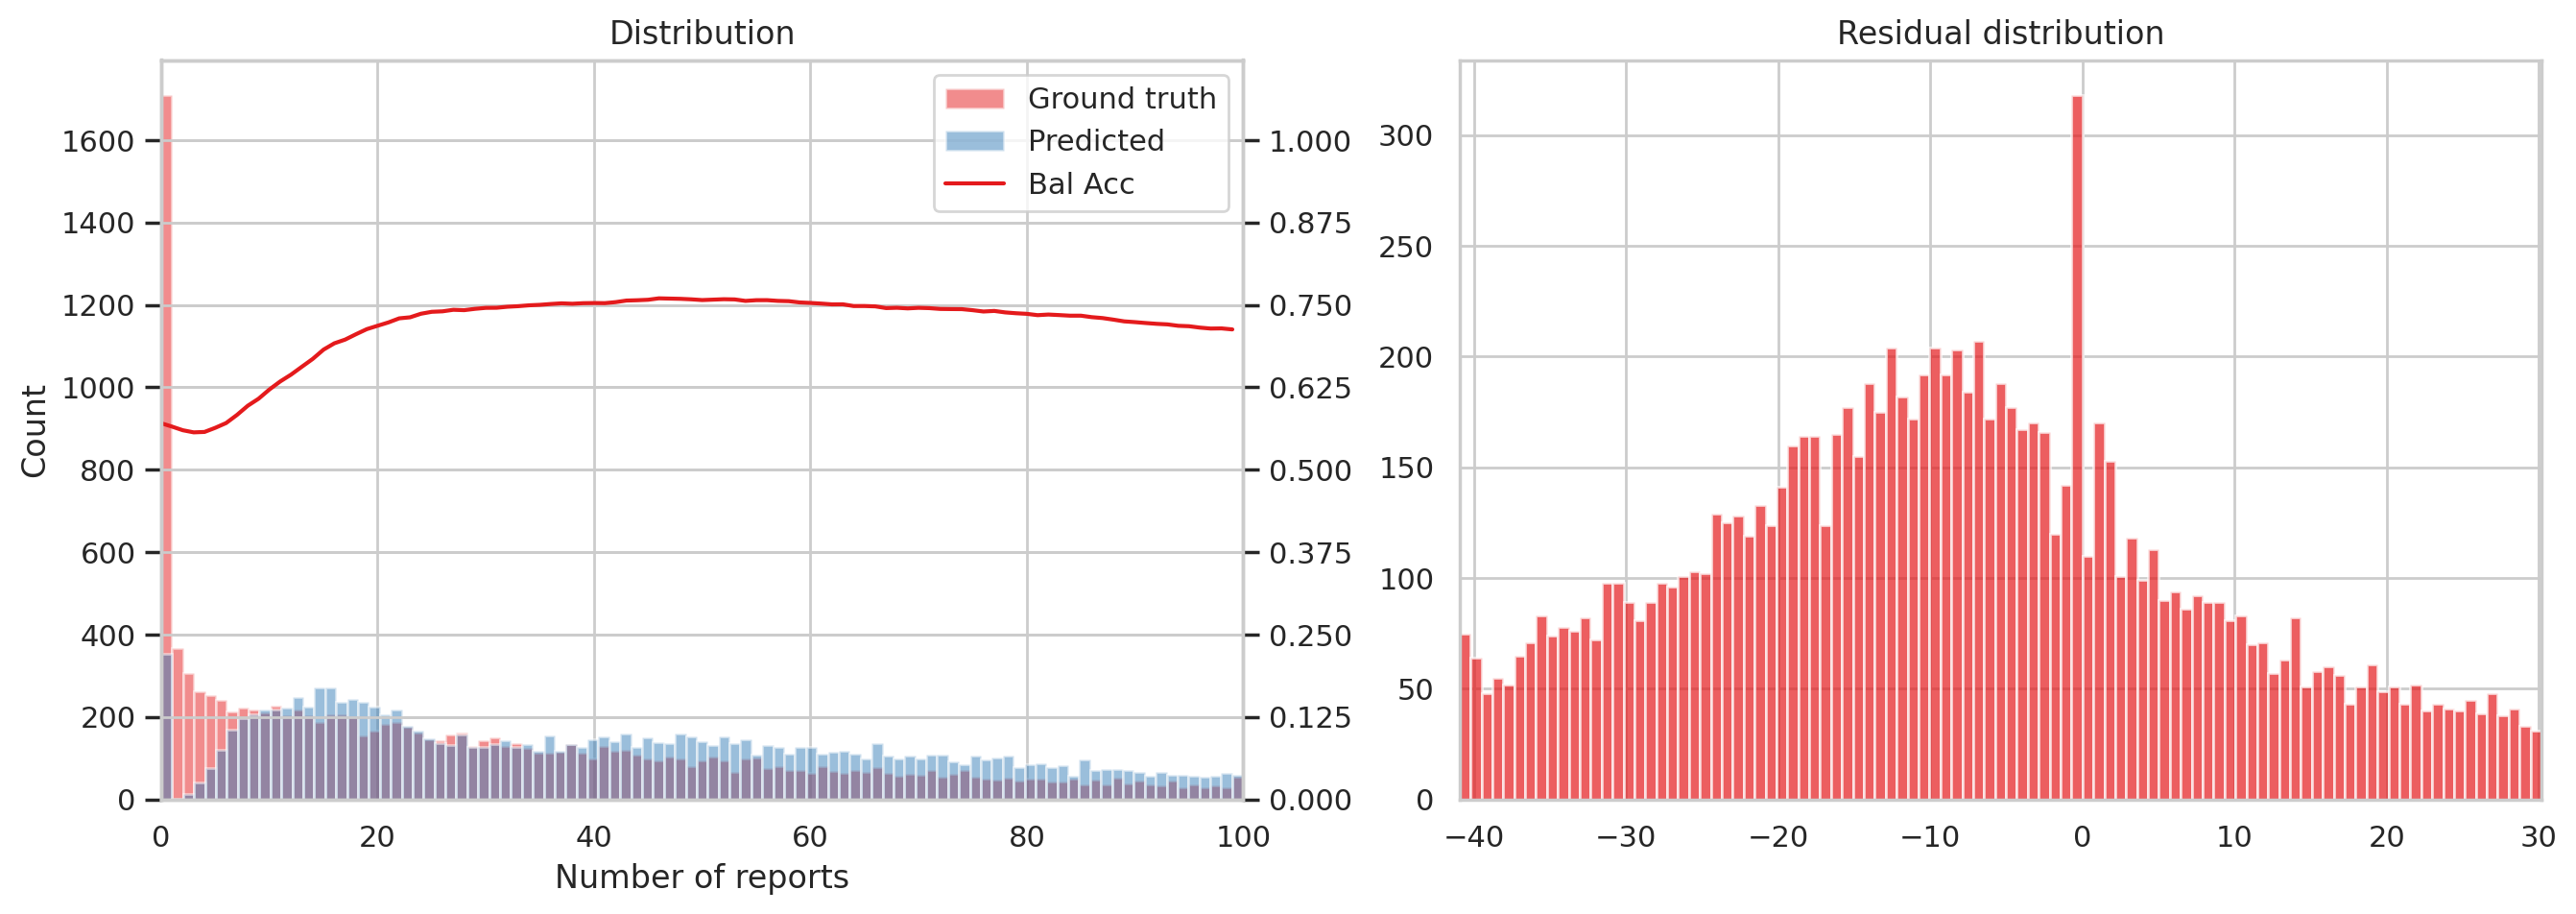

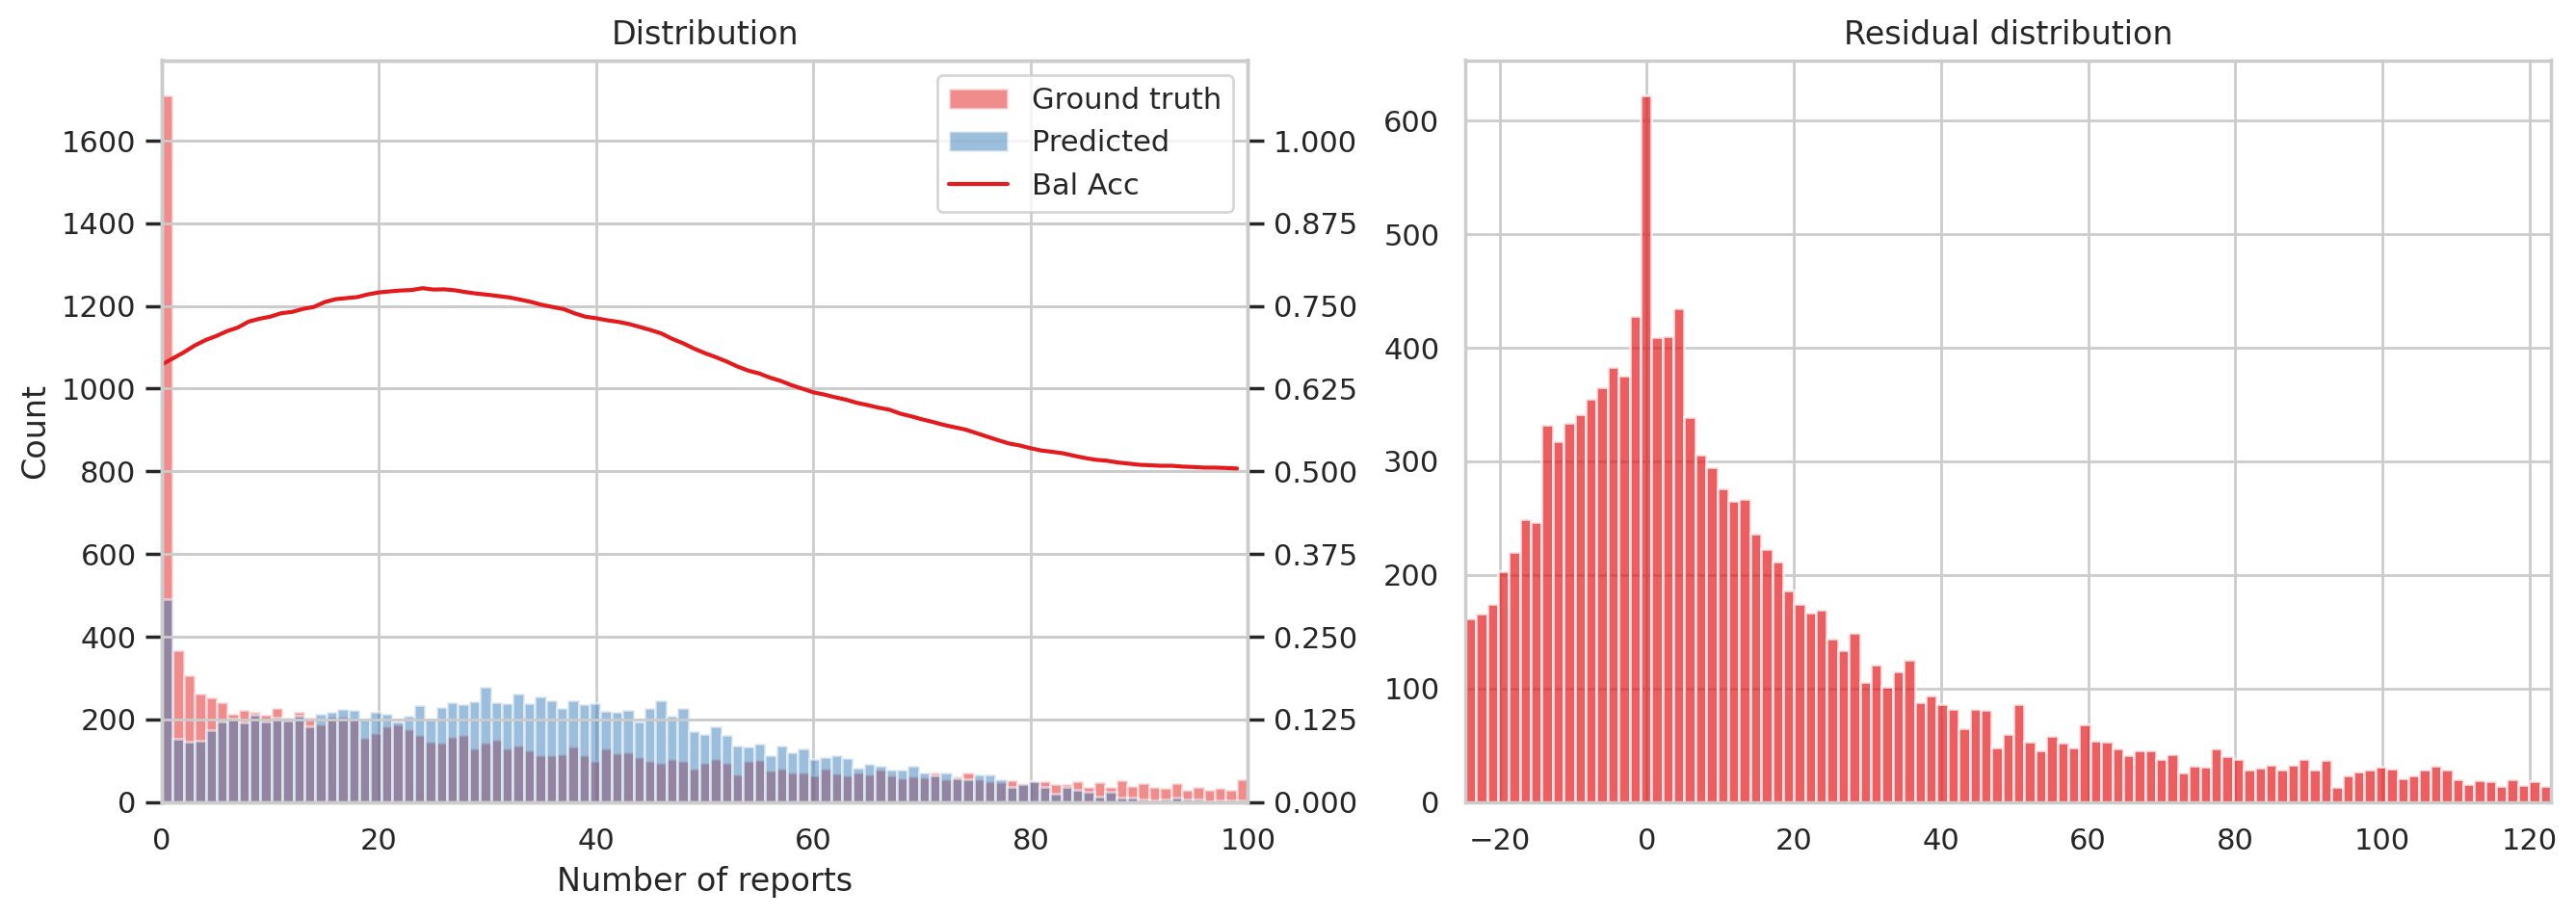

In [24]:
for model in zero_inflated_models.values():
    plot_metrics(model, X_interp, y_train)

In [13]:
# Escolhemos o modelo de Poisson Zero-inflated

final_model = zero_inflated_models["Poisson ZIR"].fit(X_interp_aug, y_aug)

In [14]:
final_model

ZeroInflatedRegressor(classifier=LogisticRegression(C=1000000000000.0,
                                                    solver='liblinear'),
                      regressor=PoissonRegressor(alpha=0.0001,
                                                 solver='newton-cholesky'))

In [26]:
features = [
    "Tempo de viagem",
    "População",
    "homicídio zero",
    "Homicídio alto",
    "Homicídio baixo",
    "Homicídio outros",
    "Sem risco",
    "Baixo risco",
    "Médio risco",
    "Alto risco",
    "Muito alto risco",
    "Sem proteção manancial",
    "Com proteção manancial",
    "Urbanizado até 29",
    "Urbanizado até 49",
    "Urbanizado até 62",
    "Urbanizado até 74",
    "Urbanizado até 85",
    "Urbanizado até 97",
    "Urbanizado até 2010",
    "Rural",
    "Não aglomerado subnormal",
    "Aglomerado subnormal",
    "Baixa densidade",
    "Méida densidade",
    "Alta densidade",
    "Muito alta densidade",
    "Cluster A",
    "Cluster B",
    "Cluster C",
    "Cluster D",
    "Cluster E",
    "Cluster F", 
    "Cluster G",
    "Cluster H",
    "Verticalização",
    "Chefes de família alta renda",
    "Atendimento de esgoto",
    "Chefes de família mulheres",
    "Domicílios particulares improvisados",
    "Tempo de deslocamento",
    "Domicílos particulares permanentes",
    "Chefes de família alfabetizados",
    "População jovem masculina",
    "Coleta de lixo",
    "Atendimento de água"
]

In [97]:
def plot_importance(models, features):
    fig, axs = plt.subplots(ncols =2, figsize=(12, 10))

    for i, (name, model) in enumerate(models.items()):
        coefs = np.array(model.coef_).squeeze()

        coefs = (coefs - coefs.mean())/coefs.std()

        idxs = np.argsort(coefs)

        coefs = coefs[idxs]

        least = max(abs(coefs[-1]), abs(coefs[0]))

        colors = 0.5 * (coefs + least)/least

        axs[i].barh(np.array(features)[idxs], coefs, color=plt.get_cmap("RdBu")(colors))

        axs[i].set_xlabel("Relative importance")
        axs[i].set_title(f"Relative importance for {name}")
    
    axs[0].set_ylabel("Features")
    plt.tight_layout()
    plt.show()


    

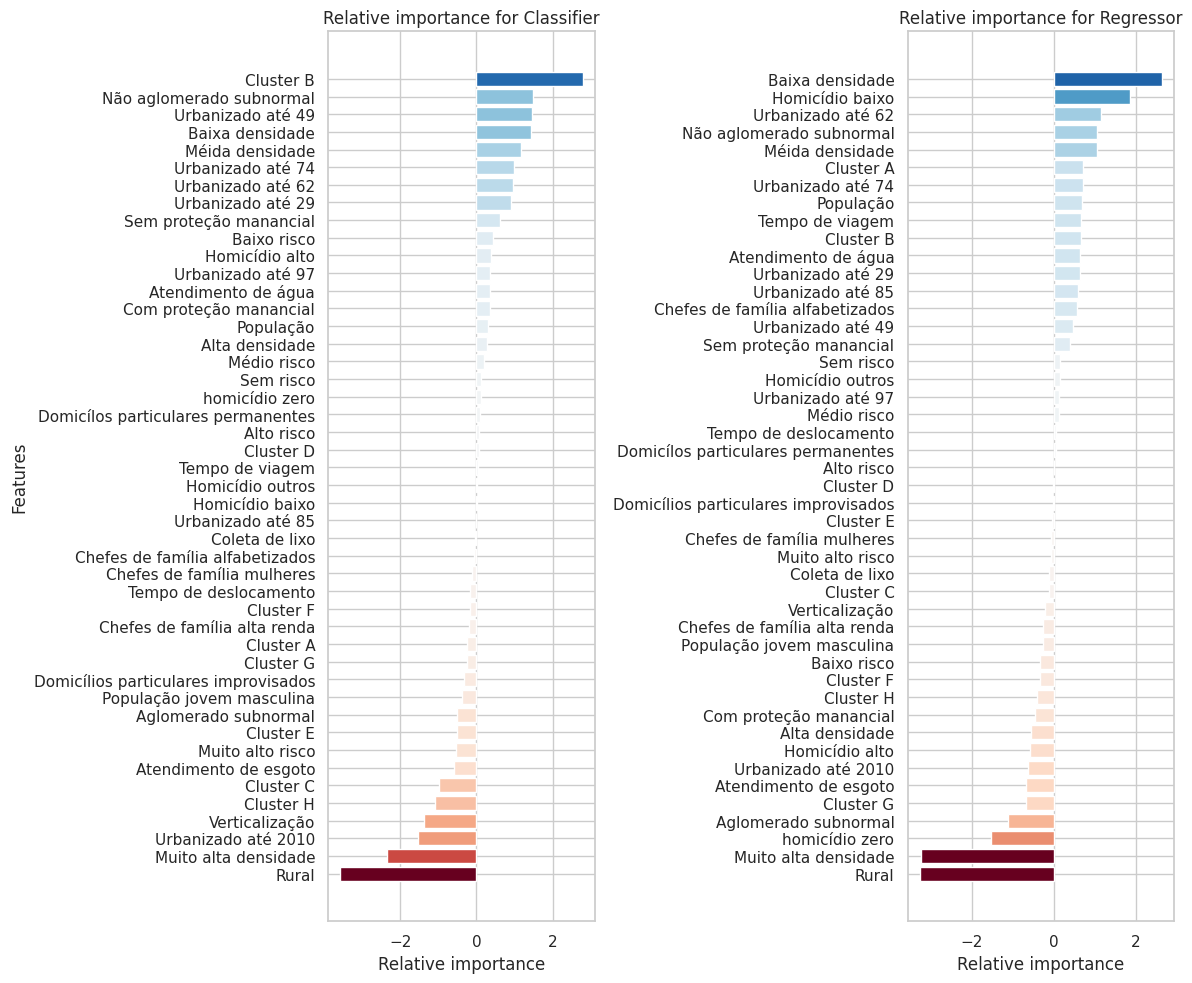

In [98]:
final_models = {
    "Classifier" : final_model.classifier_,
    "Regressor"  : final_model.regressor_
}

plot_importance(final_models, features)

### Modelos não-interpretáveis

In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor

tree_models = {
    "Standard"   : HistGradientBoostingRegressor(max_leaf_nodes=128),
    "Poisson"  : HistGradientBoostingRegressor(loss='poisson',max_leaf_nodes=128),
    "Quantile" : HistGradientBoostingRegressor(loss='quantile',max_leaf_nodes=128, quantile=0.4)
}

In [13]:
results = evaluate(tree_models, X_aug, y_aug, metrics, cv=10)

10it [00:30,  3.00s/it]
10it [00:26,  2.61s/it]
10it [00:32,  3.26s/it]


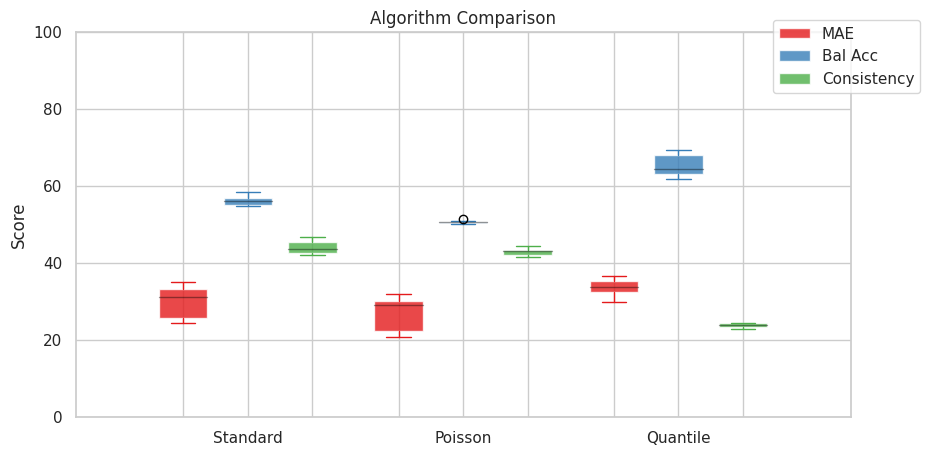

In [14]:
plot_results(results, tree_models, metrics)

In [15]:
results.applymap(reject_outliers).applymap(lambda x : f"{np.mean(x) : .3f} $\pm$ {np.std(x) :.3f}")

,MAE,Bal Acc,Consistency
Standard,29.904 $\pm$ 3.279,56.075 $\pm$ 0.857,43.858 $\pm$ 1.376
Poisson,26.889 $\pm$ 3.543,50.532 $\pm$ 0.173,42.858 $\pm$ 0.766
Quantile,33.806 $\pm$ 1.472,65.263 $\pm$ 2.296,23.757 $\pm$ 0.453


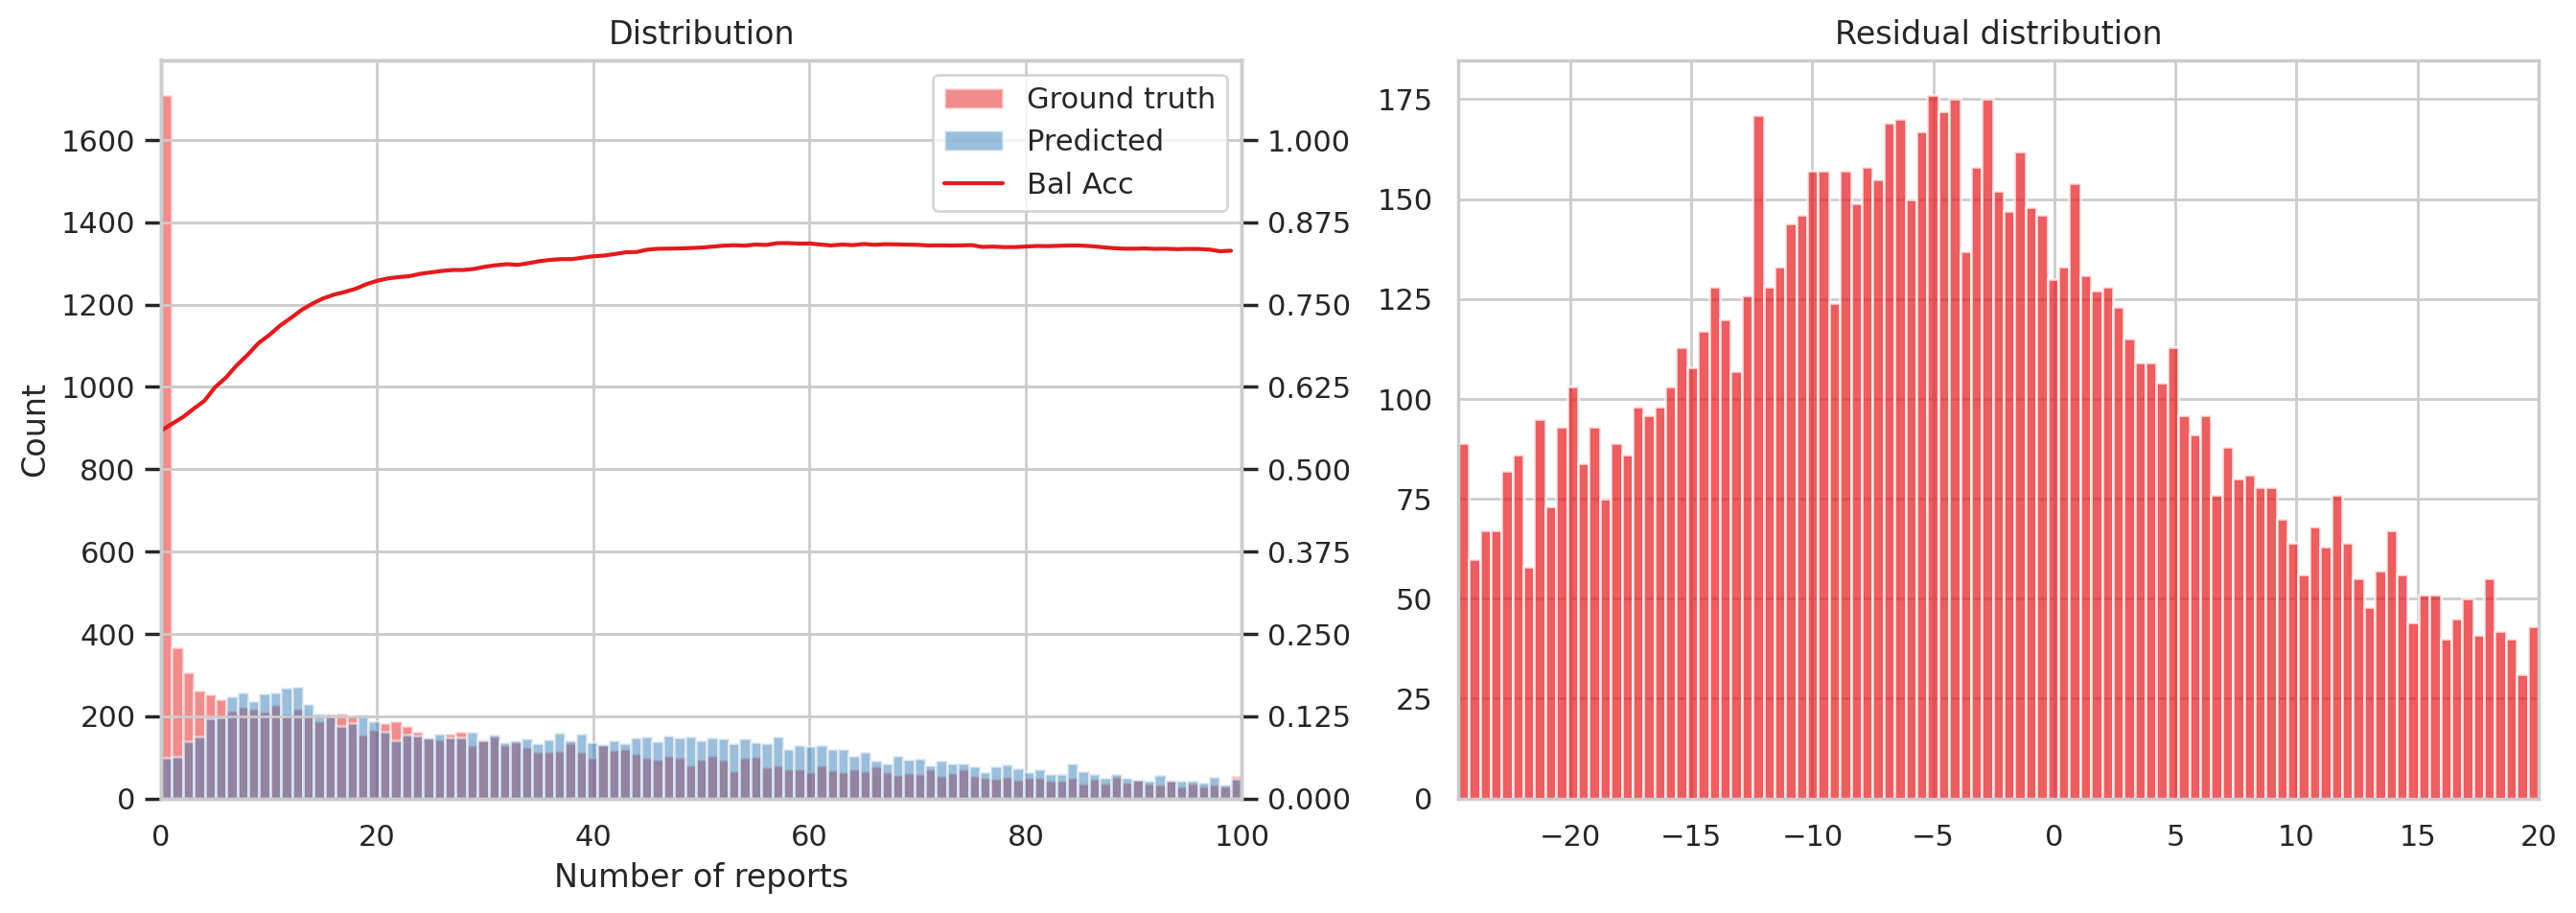

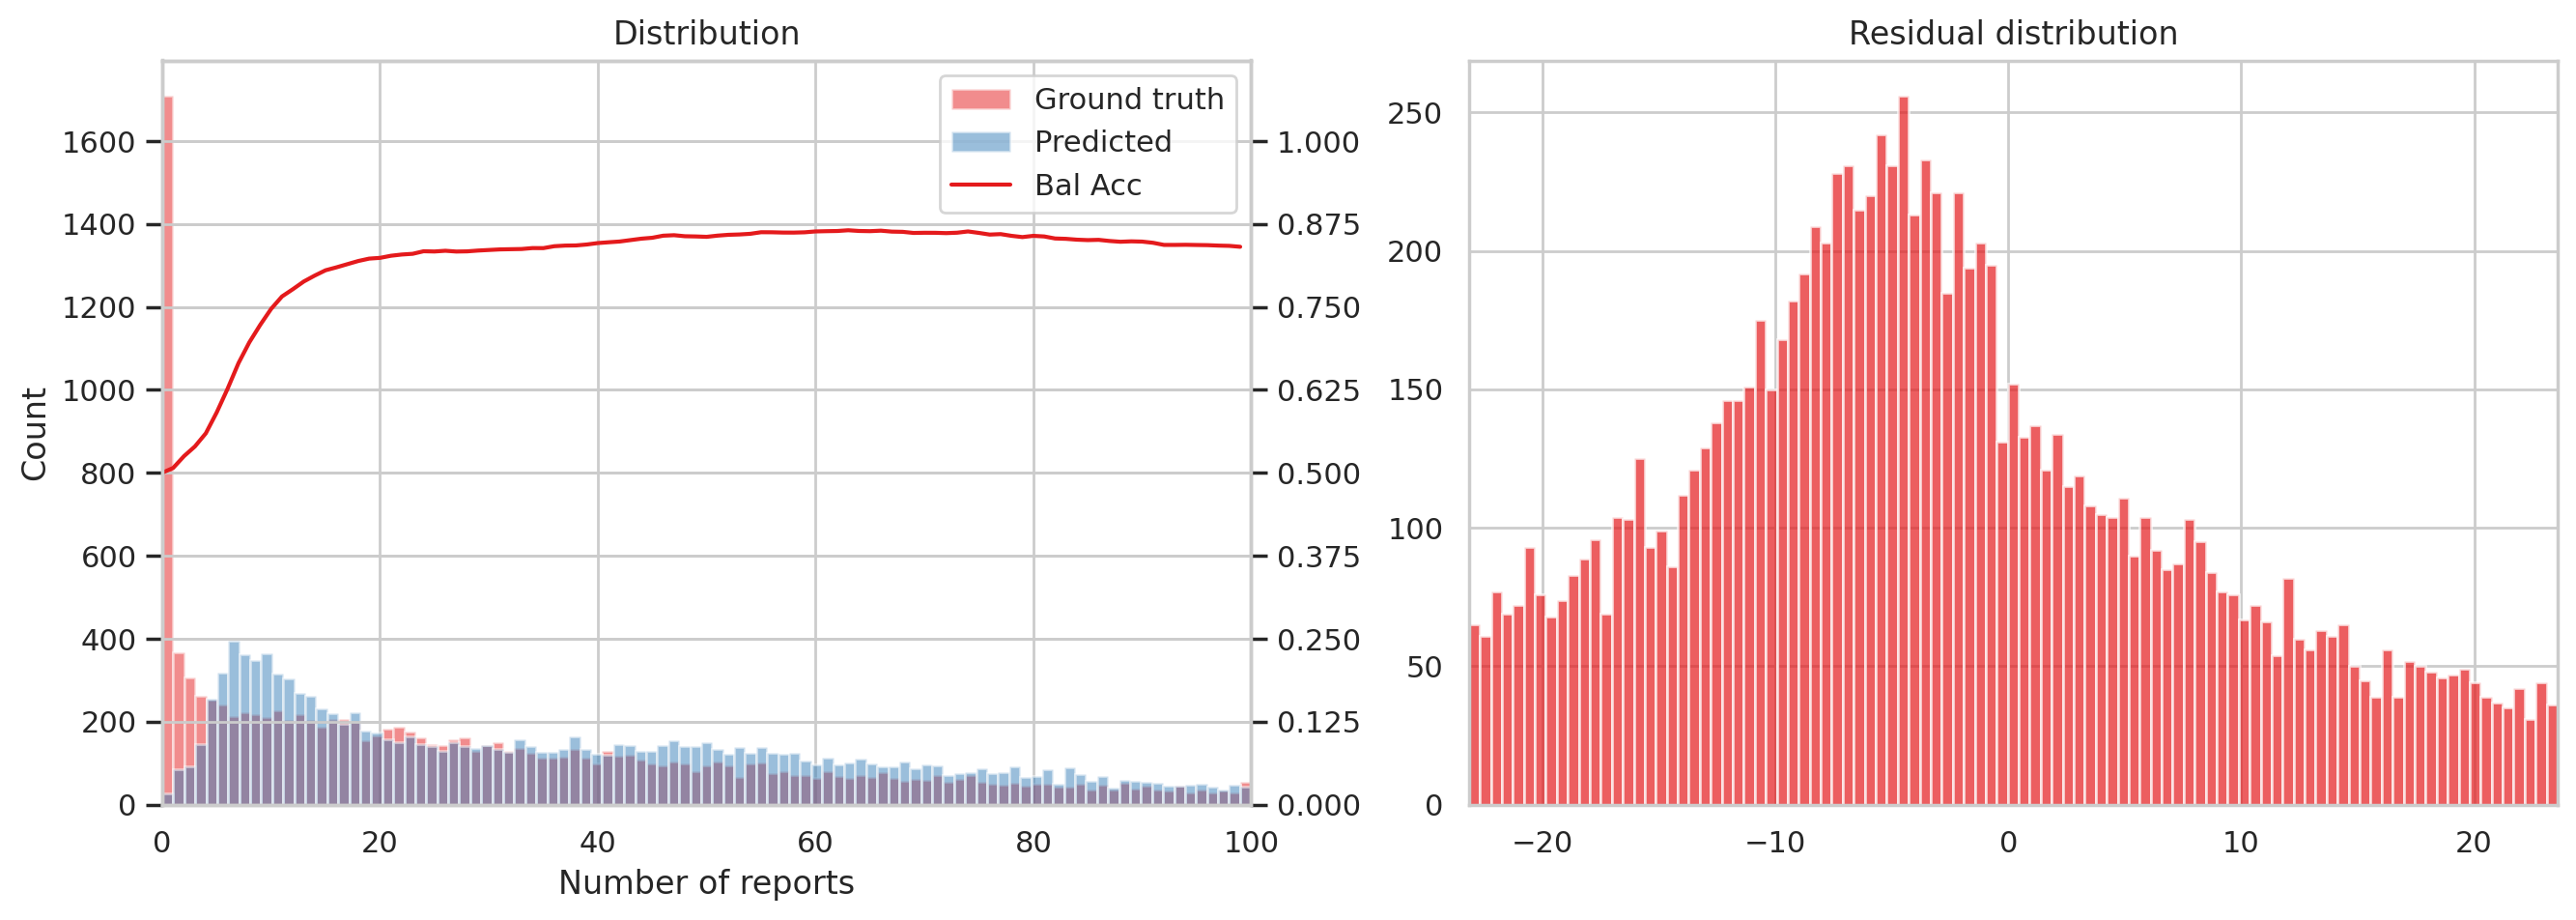

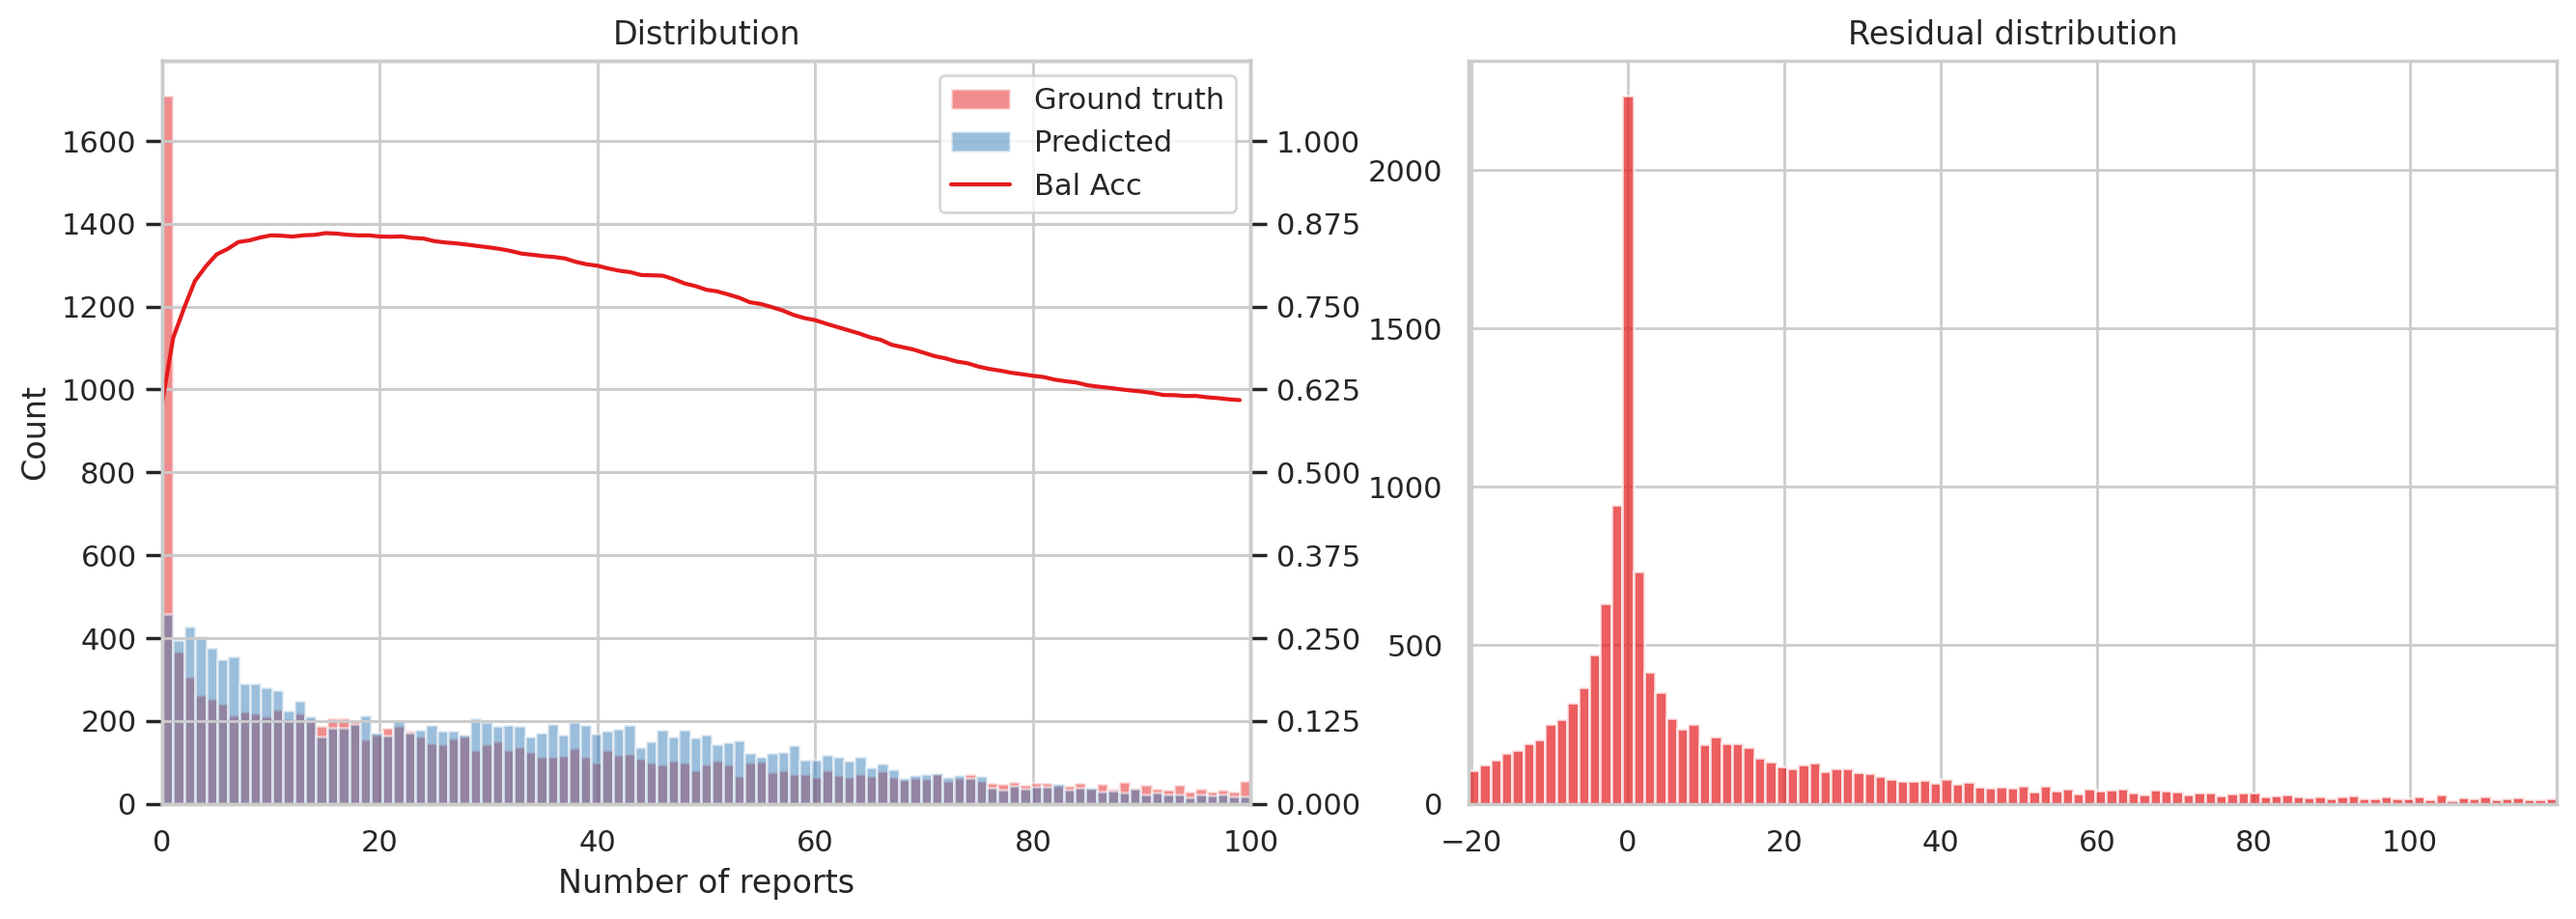

In [18]:
for model in tree_models.values():
    plot_metrics(model, X_train, y_train)

In [51]:
features = [
    "Chefes de família alta renda",
    "Homicídio",
    "Tempo de deslocamento",
    "Tempo de viagem",
    "Chefes de família alfabetizados",
    "Aglomerado subnormal",
    "Área de risco"
    "Cluster",
    "População",
    "Atendimento de esgoto",
    "Verticalização",
    "Proteção manancial",
    "Chefes de família mulheres",
    "População jovem masculina",
    "Total de Viagens",
    "Expansão Urbana",
    "Coleta de lixo",
    "Atendimento de água",
    "Domicílos particulares permanentes",
    "Domicílios particulares improvisados",
    "Densidade demográfica",
]

feature_map = dict(zip(X_test.columns, features))

X_test_renamed = X_test.rename(feature_map, axis=1)

In [52]:
import shap

explainer = shap.explainers.Tree(tree_models["Quantile"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


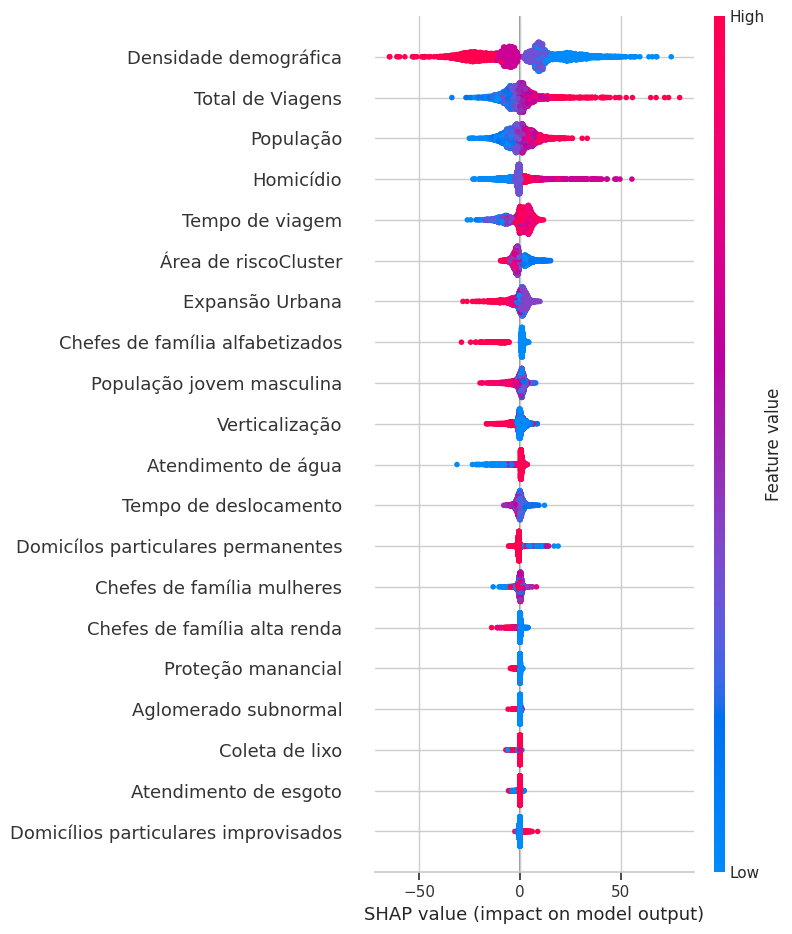

In [53]:
shap.summary_plot(explainer(X_test_renamed))

In [54]:
[categ_columns

['HOMIC', 'ARISC', 'PMANC', 'EXURB', 'AGL10', 'DEN10', 'CLUSTER']

In [38]:
from sklearn.inspection import PartialDependenceDisplay

pdp = PartialDependenceDisplay.from_estimator(tree_models["Quantile"], X_test, X_test.columns, categorical_features=categ_columns)

ValueError: Feature 'CAR10' not in feature_names